In [1]:
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.loaders import StateInteractionsLoader
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.io import load_neurons, load_derived_generic
import seaborn as sns
import pandas as pd
import numpy as np
from drn_interactions.interactions.graph_clustering import SpectralCluster, ClusterRunner, ClusterEvaluation, ClusterResults
import warnings
from drn_interactions.config import Config, ExperimentInfo
from tqdm import tqdm

dd = Config.derived_data_dir / "ensembles"
dd.mkdir(exist_ok=True)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [8]:
sessions = ExperimentInfo.eeg_sessions

preprocessor = InteractionsPreprocessor(z=True, minmax=False)
evaluator = ClusterEvaluation()

loader_fac = lambda session, state, bin_width: StateInteractionsLoader(
    session_name=session, state=state, bin_width=bin_width,
)
corr_fac = lambda: PairwiseCorr(
    remove_self_interactions=True,
    rectify=True,
    shuffle=False,
    remove_duplicate_combs=True,
)
cluster_fac = lambda: SpectralCluster(
    n_clusters=np.arange(2, 8), spectral_kws={"affinity": "precomputed"}, n_init=15
)

runner_fac = lambda session, state, bin_width: ClusterRunner(
    loader=loader_fac(session=session, state=state, bin_width=bin_width),
    preprocessor=preprocessor,
    affinity_calculator=corr_fac(),
    clusterer=cluster_fac(),
    evalulator=evaluator,
)

In [9]:
ensemble_frames = []
ensemble_stats_frames = []

for bin_width in (0.05, 0.1, 0.5, 1):
    for state in ("sw", "act"):
        for session in tqdm(sessions):

            # calculate ensembles
            runner = runner_fac(session=session, state=state, bin_width=bin_width)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    _, ensembles, _, ensemble_stats = runner.run(20)
                except ValueError as e:
                    print(e)
                    print(session)

            # add metadata and append to list of results
            ensembles = ensembles.assign(session_name=session, state=state, bin_width=bin_width)
            ensemble_stats = ensemble_stats.assign(session_name=session, state=state, bin_width=bin_width)
            ensemble_stats_frames.append(ensemble_stats)
            ensemble_frames.append(ensembles)

df_ensembles = pd.concat(ensemble_frames).reset_index(drop=True)
df_ensembles_stats = pd.concat(ensemble_stats_frames).reset_index(drop=True)

df_ensembles_stats["ensemble_id"] = pd.factorize(
    df_ensembles_stats["ensemble"].astype(str)
    + df_ensembles_stats["session_name"]
    + df_ensembles_stats["state"]
    + df_ensembles_stats["bin_width"].astype(str)
)[0]
df_ensembles_stats["ensemble_id"] = np.where(
    df_ensembles_stats["ensemble"] == -1,
    -1,
    df_ensembles_stats["ensemble_id"],
)
df_ensembles = (
    df_ensembles_stats
    [["session_name", "ensemble", "ensemble_id", "state"]].merge(
        df_ensembles, on=["session_name", "ensemble", "state"]
    )
)


df_ensembles.to_csv(dd / "bs - ensembles.csv", index=False)
df_ensembles_stats.to_csv(dd / "bs - stats.csv", index=False)


 93%|█████████▎| 14/15 [3:05:54<10:13, 613.80s/it]  

attempt to get argmax of an empty sequence
acute_12


 33%|███▎      | 5/15 [53:48<1:29:25, 536.54s/it]

attempt to get argmax of an empty sequence
ESHOCK_08_LOC1


 67%|██████▋   | 10/15 [1:51:56<45:58, 551.79s/it] 

attempt to get argmax of an empty sequence
hamilton_09


 93%|█████████▎| 14/15 [3:04:56<10:11, 611.18s/it]  

attempt to get argmax of an empty sequence
acute_12


 33%|███▎      | 5/15 [53:23<1:28:33, 531.31s/it]

attempt to get argmax of an empty sequence
ESHOCK_08_LOC1


 67%|██████▋   | 10/15 [1:50:38<45:19, 543.86s/it] 

attempt to get argmax of an empty sequence
hamilton_09


 93%|█████████▎| 14/15 [3:02:28<10:02, 602.44s/it]  

attempt to get argmax of an empty sequence
acute_12


 33%|███▎      | 5/15 [52:54<1:27:55, 527.53s/it]

attempt to get argmax of an empty sequence
ESHOCK_08_LOC1


 67%|██████▋   | 10/15 [1:50:00<45:11, 542.27s/it] 

attempt to get argmax of an empty sequence
hamilton_09


 93%|█████████▎| 14/15 [3:03:17<10:07, 607.95s/it]  

attempt to get argmax of an empty sequence
acute_12


 33%|███▎      | 5/15 [53:28<1:28:54, 533.46s/it]

attempt to get argmax of an empty sequence
ESHOCK_08_LOC1


 67%|██████▋   | 10/15 [1:51:12<45:42, 548.54s/it] 

attempt to get argmax of an empty sequence
hamilton_09


100%|██████████| 15/15 [3:05:07<00:00, 740.50s/it]


KeyError: 'bin_width'

<AxesSubplot:xlabel='bin_width', ylabel='Number of Ensembles'>

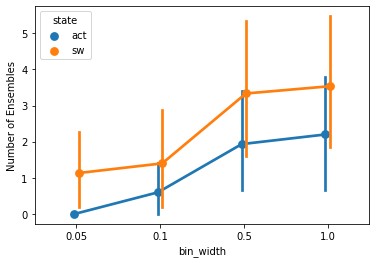

In [62]:
(
    df_ensembles
    .groupby(["session_name", "state", "bin_width"])
    ["ensemble_id"]
    .nunique()
    .subtract(1)
    .to_frame("Number of Ensembles")
    .reset_index()
    .pipe((sns.pointplot, "data"), x="bin_width", y="Number of Ensembles", hue="state", estimator=np.mean, dodge=True)
)

In [63]:
import seaborn as sns
import pingouin as pg

dfp = (
    df_ensembles
    .groupby(["session_name", "state"])["ensemble_id"]
    .nunique()
    .subtract(1)
    .to_frame("Num Ensembles")
    .reset_index()
    # .pivot(index="session_name", columns="state", values="Num Ensembles")
    # .pipe((sns.barplot, "data"), x="state", y="Num Ensembles", hue="state")
)

In [64]:
from scipy.stats import wilcoxon
from drn_interactions.stats import mannwhitneyu_plusplus

piv = dfp.pivot(index="session_name", columns="state", values="Num Ensembles")
x = piv.sw
y = piv.act
mannwhitneyu_plusplus(x, y, names=("sw", "act"), compare_f=wilcoxon)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n_sw        15.000000
n_act       15.000000
Mean_sw      3.800000
Mean_act     2.533333
Diff        -1.266667
U           13.000000
p            0.259136
dtype: float64

<AxesSubplot:xlabel='state', ylabel='Num Ensembles'>

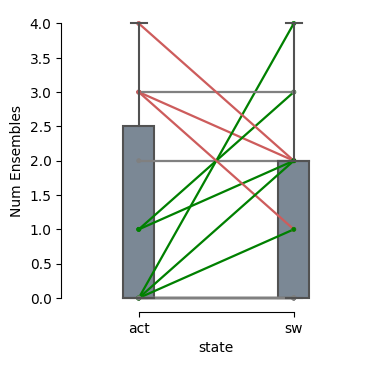

In [40]:
pg.plot_paired(dfp, dv="Num Ensembles", within="state", subject="session_name")

<AxesSubplot:xlabel='state', ylabel='average_degree'>

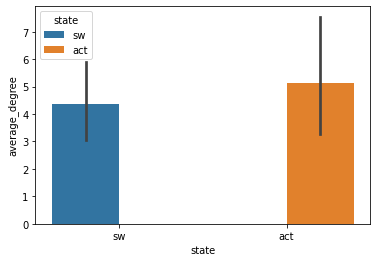

In [43]:
(
    df_ensembles_stats.query("ensemble_id != -1")
    .pipe((sns.barplot, "data"), x="state", y="average_degree", hue="state")
)

In [44]:
df_ensembles_stats.columns

Index(['ensemble_orig', 'size', 'average_degree', 'average_weight',
       'normalized_cut_size', 'internal_density', 'cut_size', 'conductance',
       'edge_expantion', 'average_degree_p', 'average_weight_p',
       'normalized_cut_size_p', 'conductance_p', 'edge_expantion_p',
       'ensemble', 'session_name', 'state', 'ensemble_id'],
      dtype='object')

edge_expantion
n_sw         26.000000
n_act        19.000000
Mean_sw       0.867305
Mean_act      1.111872
Diff          0.244567
U           181.000000
p             0.132239
dtype: float64


<AxesSubplot:xlabel='state', ylabel='edge_expantion'>

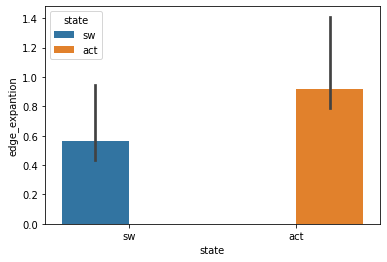

In [61]:
metric = "edge_expantion"

x = df_ensembles_stats.query("ensemble_id != -1 and state == 'sw'")[metric].values
y = df_ensembles_stats.query("ensemble_id != -1 and state == 'act'")[metric].values
print(metric)
print(mannwhitneyu_plusplus(x, y, names=("sw", "act")))

(
    df_ensembles_stats.query("ensemble_id != -1")
    .pipe((sns.barplot, "data"), x="state", y=metric, hue="state", estimator=np.median)
)

conductance
n_sw         26.000000
n_act        19.000000
Mean_sw       0.361345
Mean_act      0.426921
Diff          0.065576
U           194.000000
p             0.227600
dtype: float64


<AxesSubplot:xlabel='state', ylabel='conductance'>

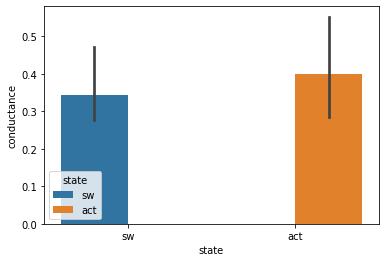

In [62]:
metric = "conductance"

x = df_ensembles_stats.query("ensemble_id != -1 and state == 'sw'")[metric].values
y = df_ensembles_stats.query("ensemble_id != -1 and state == 'act'")[metric].values
print(metric)
print(mannwhitneyu_plusplus(x, y, names=("sw", "act")))

(
    df_ensembles_stats.query("ensemble_id != -1")
    .pipe((sns.barplot, "data"), x="state", y=metric, hue="state", estimator=np.median)
)

size
n_sw         26.000000
n_act        19.000000
Mean_sw       7.807692
Mean_act      8.789474
Diff          0.981781
U           247.000000
p             1.000000
dtype: float64


<AxesSubplot:xlabel='state', ylabel='size'>

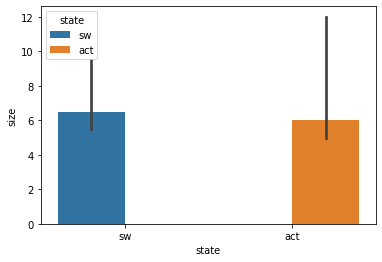

In [63]:
metric = "size"

x = df_ensembles_stats.query("ensemble_id != -1 and state == 'sw'")[metric].values
y = df_ensembles_stats.query("ensemble_id != -1 and state == 'act'")[metric].values
print(metric)
print(mannwhitneyu_plusplus(x, y, names=("sw", "act")))

(
    df_ensembles_stats.query("ensemble_id != -1")
    .pipe((sns.barplot, "data"), x="state", y=metric, hue="state", estimator=np.median)
)

cut_size
n_sw         26.000000
n_act        19.000000
Mean_sw       7.086170
Mean_act      8.915045
Diff          1.828875
U           198.000000
p             0.265007
dtype: float64


<AxesSubplot:xlabel='state', ylabel='cut_size'>

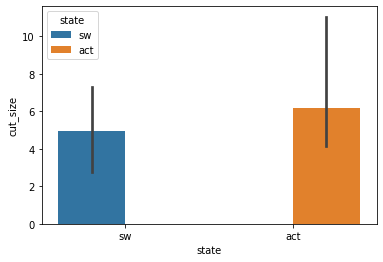

In [64]:
metric = "cut_size"

x = df_ensembles_stats.query("ensemble_id != -1 and state == 'sw'")[metric].values
y = df_ensembles_stats.query("ensemble_id != -1 and state == 'act'")[metric].values
print(metric)
print(mannwhitneyu_plusplus(x, y, names=("sw", "act")))

(
    df_ensembles_stats.query("ensemble_id != -1")
    .pipe((sns.barplot, "data"), x="state", y=metric, hue="state", estimator=np.median)
)